# Implementation of the tensor completion algorithm with BSA

Necessary files: testing_functions.py, tensor_completion_functions.py, pyten.zip, BRA.csv

In [ ]:
import testing_functions
import tensor_completion_functions
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.utils.extmath import randomized_svd
import seaborn as sns

I used the implementation of the tensor completion algorithms from the package Pyten: https://github.com/datamllab/pyten.

Importing Pyten.

In [ ]:
!unzip /content/pyten.zip -d /content/pyten

Archive:  /content/pyten.zip
   creating: /content/pyten/pyten/
   creating: /content/pyten/pyten/content/
   creating: /content/pyten/pyten/content/pyten/
   creating: /content/pyten/pyten/content/pyten/pyten/
  inflating: /content/pyten/pyten/content/pyten/pyten/.DS_Store  
   creating: /content/pyten/pyten/content/pyten/pyten/.git/
   creating: /content/pyten/pyten/content/pyten/pyten/.git/branches/
  inflating: /content/pyten/pyten/content/pyten/pyten/.git/config  
  inflating: /content/pyten/pyten/content/pyten/pyten/.git/description  
 extracting: /content/pyten/pyten/content/pyten/pyten/.git/HEAD  
   creating: /content/pyten/pyten/content/pyten/pyten/.git/hooks/
  inflating: /content/pyten/pyten/content/pyten/pyten/.git/hooks/applypatch-msg.sample  
  inflating: /content/pyten/pyten/content/pyten/pyten/.git/hooks/commit-msg.sample  
  inflating: /content/pyten/pyten/content/pyten/pyten/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/pyten/pyten/content/pyten/pyten/

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=336fa28ffb3ae78bdddfd19d3e8377332e16d71c69ce66bdf6f7f770536c4fe9
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [ ]:
!cd pyten/pyten/content/pyten/pyten; pip install .
import pyten

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/pyten/pyten/content/pyten/pyten
  Preparing metadata (setup.py) ... done
  Created wheel for pyten: filename=pyten-1.0.0-py3-none-any.whl size=82191 sha256=6c044498b8007aaad7af294bb5ee5f141b3293b3ebf7be0a0758a0ae46ab1ba8
  Stored in directory: /tmp/pip-ephem-wheel-cache-guzufudn/wheels/30/44/e3/7ceb1a8149efc872b717846fdef5c8012f25ce729e15498d11
Successfully built pyten


I used seasons from from 2012 to first half of 18 season as training dataset and second half of 2018 season for validation. The algorithm was tested on the second half of the 2019 season.


In [ ]:
full_dataset = pd.read_csv('BRA.csv')
full_dataset.rename(columns = {'Home':'HomeTeam', 'Away': 'AwayTeam',
                               'HG': 'FTHG', 'AG': 'FTAG', 'Res': 'FTR',
                               'PH': 'B365H', 'PD': 'B365D',
                               'PA': 'B365A'}, inplace = True)
for season in full_dataset['Season'].unique():
  dataset = full_dataset[full_dataset['Season'] == season]
  dataset.to_csv('BSA_' + str(season)[-2:] + '.csv', index=False)

In [ ]:
train_validation_files = ['BSA_12.csv', 'BSA_13.csv',
                 'BSA_14.csv', 'BSA_15.csv', 'BSA_16.csv', 'BSA_17.csv',
                 'BSA_18.csv']

TNCP was chosen as the tensor completion algorithm with the maximum number of iterations of 20. This was set according to the experiments done on the EPL dataset.

In [ ]:
best_iterations_TNCP = 20

I searched for best hyperparameters threshold and r. For each hyperparameters combination is the model trained on the training data and evaluated on the second half of the 2018 season, which is the validation dataset. The hyperparameter combination with the best validation accuracy is chosen.

In [ ]:
param_grid = {
    'threshold': [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25],
    'r': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}
param_comb = ParameterGrid(param_grid)

val_scores = []
for params in param_comb:
    # Training on the first half of the season and predicting the second half.
    score = tensor_completion_functions.predict_season(train_validation_files, 0.5, '3', 1e-10,
                           best_iterations_TNCP, pyten, **params)
    val_scores.append(score)
    print(params, ' ', score)

best_params = param_comb[np.argmax(val_scores)]
print(best_params)
print(np.max(val_scores))

{'r': 2, 'threshold': 0}   0.5526315789473685
{'r': 2, 'threshold': 0.025}   0.5578947368421052
{'r': 2, 'threshold': 0.05}   0.5631578947368421
{'r': 2, 'threshold': 0.075}   0.5526315789473685
{'r': 2, 'threshold': 0.1}   0.5894736842105263
{'r': 2, 'threshold': 0.125}   0.5526315789473685
{'r': 2, 'threshold': 0.15}   0.5842105263157895
{'r': 2, 'threshold': 0.175}   0.4842105263157895
{'r': 2, 'threshold': 0.2}   0.5368421052631579
{'r': 2, 'threshold': 0.225}   0.5526315789473685
{'r': 2, 'threshold': 0.25}   0.5105263157894737
{'r': 3, 'threshold': 0}   0.5210526315789473
{'r': 3, 'threshold': 0.025}   0.5421052631578948
{'r': 3, 'threshold': 0.05}   0.5473684210526316
{'r': 3, 'threshold': 0.075}   0.5631578947368421
{'r': 3, 'threshold': 0.1}   0.5
{'r': 3, 'threshold': 0.125}   0.5368421052631579
{'r': 3, 'threshold': 0.15}   0.5684210526315789
{'r': 3, 'threshold': 0.175}   0.5473684210526316
{'r': 3, 'threshold': 0.2}   0.5684210526315789
{'r': 3, 'threshold': 0.225}   0.542

The highest validation accuracy was achieved with threshold of 0.1 and r of 2.

In [ ]:
best_function = '3'
best_threshold = 0.1
best_r = 2

I used second half of season 2019 as testing dataset. For evaluation on the testing dataset I divided the testing data into rounds approximately. The model is trained on the the training dataset, it is evaluated on one round of the testing dataset and this round is added to the training dataset.

In [ ]:
testing_files = ['BSA_12.csv', 'BSA_13.csv',
                 'BSA_14.csv', 'BSA_15.csv', 'BSA_16.csv', 'BSA_17.csv',
                 'BSA_18.csv', 'BSA_19.csv']

In [ ]:
res, cm = tensor_completion_functions.test_season(testing_files, 0.5, best_function, 1e-10, best_iterations_TNCP, best_threshold, pyten, r=best_r, return_cm=True)
res

0.45454545454545453
0.6428571428571429
0.2
0.5833333333333334
0.47058823529411764
0.5454545454545454
0.46153846153846156
0.6470588235294118
0.3333333333333333
0.5454545454545454
0.625
0.45454545454545453
0.38461538461538464
0.6470588235294118


0.5052631578947369

The testing accuracy is 50.53%.

I ploted the confusion matrix.

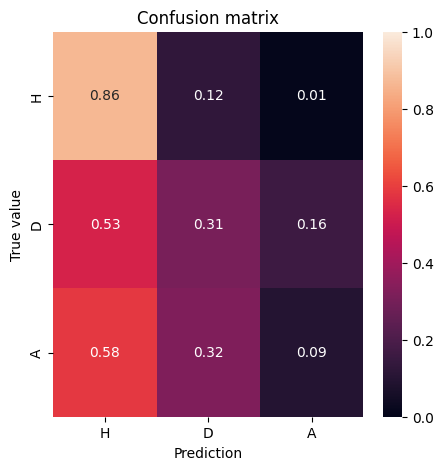

In [ ]:
tensor_completion_functions.plot_cm(cm)

I extracted the feature vectors from the last season of the fullfilled tensor. I experimented, whether it is better to extract the vectors before or after apllying the threshold. I saved the feature matrices  into csv files.

In [ ]:
H, A, teams = tensor_completion_functions.get_svd(train_validation_files, 0.5, best_function, 1e-10, best_iterations_TNCP, best_threshold, pyten, r=best_r)

In [ ]:
tensor_completion_functions.save_matrices(H, A, teams, "H_BSA.csv", "A_BSA.csv")

In [ ]:
H_before_threshold, A_before_threshold, teams = tensor_completion_functions.get_svd(train_validation_files, 0.5, best_function, 1e-10, best_iterations_TNCP, best_threshold, pyten, r=best_r,
                      before_threshold=True)

In [ ]:
tensor_completion_functions.save_matrices(H_before_threshold, A_before_threshold, teams, "H_BSA_before_threshold.csv", "A_BSA_before_threshold.csv")